# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


Lets create a matrix that highlights the corerlations for all columns at a high level, and get some ideas on where to further investigate and looks more closely

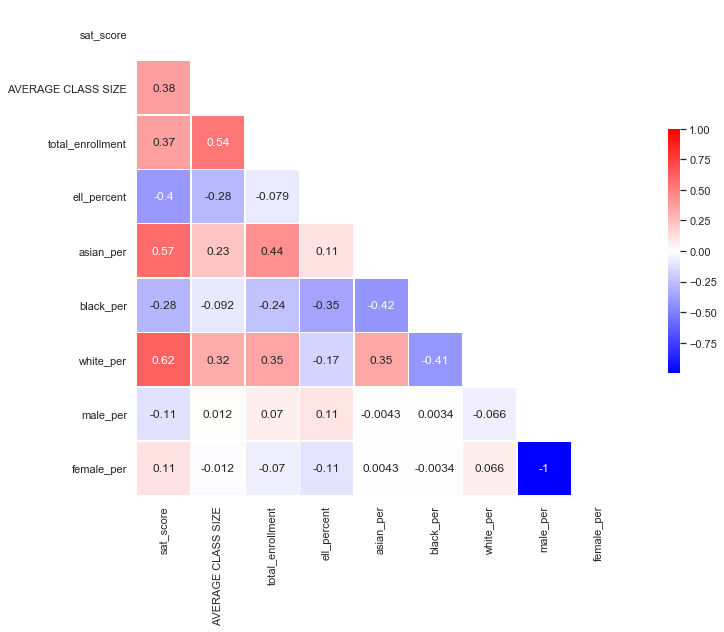

In [39]:
sns.set(style="white")

# Get interesting columns to plot
interesting_cols = ([
    'sat_score',
    'AVERAGE CLASS SIZE', 
    'total_enrollment',
    'ell_percent',
    'asian_per',
    'black_per',
    'white_per',
    'male_per',
    'female_per',
])

interesting_corr = combined[interesting_cols].corr() 

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(interesting_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))

# Draw the heatmap with the mask and correct aspect ratio
chart = sns.heatmap(interesting_corr, mask=mask, cmap="bwr", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

chart.set_yticklabels(chart.get_yticklabels(), rotation=0)

plt.show()

# Plotting survey correlations

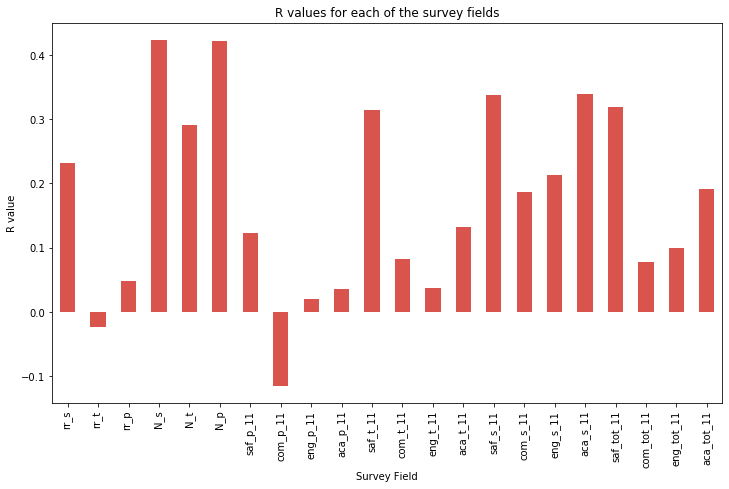

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
plt.figure(figsize=(12,7))
ax = correlations[survey_fields].plot.bar(color=sns.xkcd_rgb['pale red'])
ax.set_title('R values for each of the survey fields')
ax.set_ylabel('R value')
ax.set_xlabel('Survey Field')
plt.show()

##### Observations from correlations of the survey data with sat scores
- the strongest positive correlations are N_s (number of student respondents) and N_p (number of parent respondents) one possible hypothesis could be that students and teachers are more likley to respond to a survey when they are satisfied with the performance of the school. The same could be hypothesised about the rr_s (response rate of students)
- com_p_11 (communication score based on parents responses) is the biggest negative correlation which is interesting, this means that the higher the SAT score it seems the lower parents rated the communication. Possibly the parents are hearing less from the school when the students are performing well.
- Safety and respect scores from both students and teachers was positive correlated with the SAT results

It will be interesting to dig a little deeper into the safety and respect, as well as the communication scores by parents


### Investigation of Safety and Respect


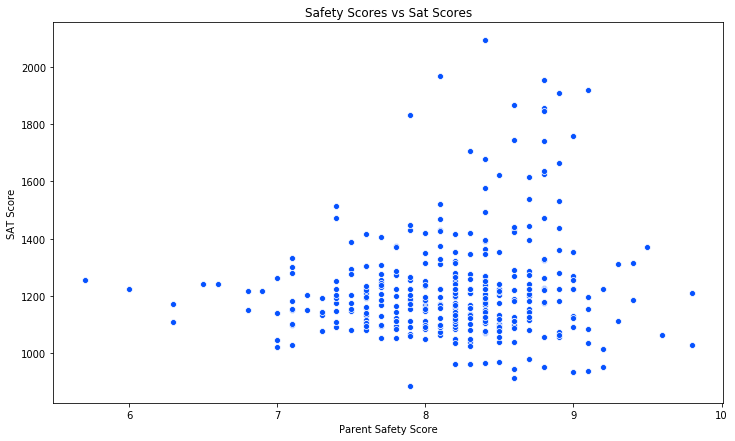

In [11]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(data=combined, x='saf_p_11', y='sat_score', color=sns.xkcd_rgb['electric blue'])
ax.set_title('Safety Scores vs Sat Scores')
ax.set_xlabel('Parent Safety Score')
ax.set_ylabel('SAT Score')
plt.show()

Based on the above scatter plot, it looks like there is a cluster of safety ratings around 1200 on the SAT, as the safety score increases it appears there is a slight upwards trend, however the spread gets much larger around a safety rating of 9. 

Let's see if we can find out any difference between districts by mapping it out.

### Mapping the safety score on a map

In [12]:
combined['saf_tot_11']

0      6.7
1      6.8
2      7.9
3      6.9
4      7.8
      ... 
358    6.7
359    7.3
360    6.9
361    9.3
362    7.4
Name: saf_tot_11, Length: 363, dtype: float64

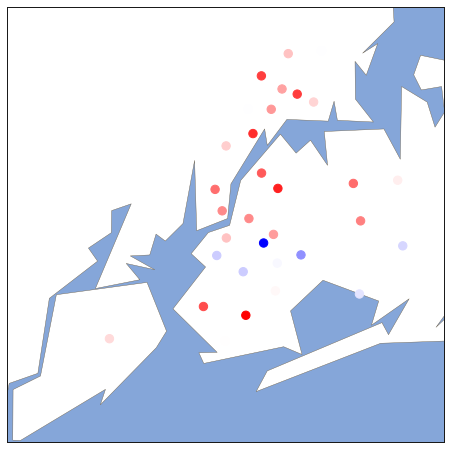

In [41]:
from mpl_toolkits.basemap import Basemap


plt.figure(figsize=(12,8))
# Create the map of NewYork that we can plot on top of
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')


saf_dist = combined.groupby('school_dist').mean()[['saf_tot_11', 'lat','lon']]
longitudes = saf_dist['lon'].tolist()
latitudes = saf_dist['lat'].tolist()

m.scatter(x=longitudes, y=latitudes, s=70, zorder=2, latlon=True, c=(saf_dist['saf_tot_11']/10), cmap="bwr")
plt.show()

It looks like along the coast Manhattan and Bronx have a slightly higher average safety rating compared to the middle parts of Brooklyn. (Blue being the lower end of the sclae and red being the higher)

### Determining the correlation between race and sat scores
We have a few columns that represent race data
- white_per
- asian_per
- black_per
- hispanic_per

Lets plot these out on a correlation matrixs to better visualise the correlation.

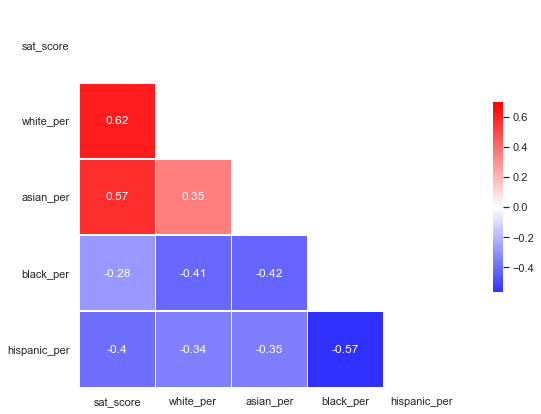

In [14]:
sns.set(style="white")

race_df = combined[['sat_score','white_per', 'asian_per','black_per', 'hispanic_per']]

# Compute the correlation matrix
corr = race_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 7))


# Draw the heatmap with the mask and correct aspect ratio
chart = sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

chart.set_yticklabels(chart.get_yticklabels(), rotation=0)

plt.show()

As we can see along that first column of the matrix, black and hispanic are both negatively correlated with SAT scores, whilst white and asian sat scores were both positively correlated. Let's dig a little deeper into hispanic

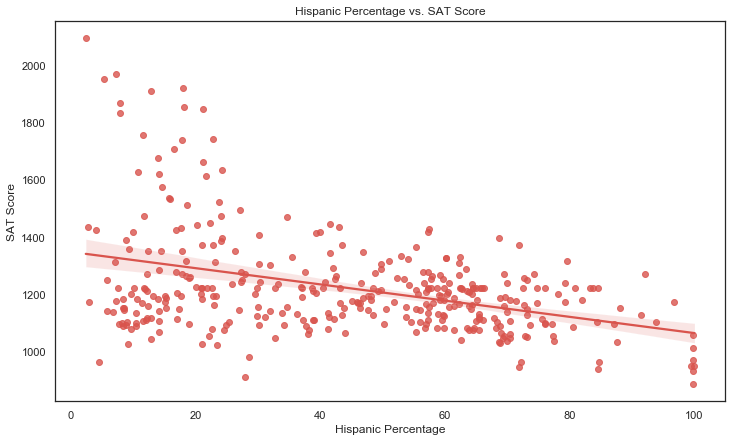

In [15]:
hispanic = combined[['DBN','SCHOOL NAME','hispanic_per','sat_score','school_type']].sort_values(by=['hispanic_per', 'sat_score'], ascending=False)
plt.figure(figsize=(12,7))
ax = sns.regplot(data=hispanic, x='hispanic_per', y='sat_score', color=sns.xkcd_rgb['pale red'])
ax.set_title('Hispanic Percentage vs. SAT Score')
ax.set_xlabel('Hispanic Percentage')
ax.set_ylabel('SAT Score')
plt.show()

It looks like as the percentage of hispanic students increases the SAT scores decrease, and at 100% there are a number of schools with really low average SAT scores.

In [16]:
hispanic.head(15)


,DBN,SCHOOL NAME,hispanic_per,sat_score,school_type
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0,International School
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0,0
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0,0
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0,International School
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0,0
253,19K583,MULTICULTURAL HIGH SCHOOL,99.8,887.0,0
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0,0
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0,0
81,06M346,COMMUNITY HEALTH ACADEMY OF THE HEIGHTS,93.8,1105.0,0
80,06M293,CITY COLLEGE ACADEMY OF THE ARTS,92.0,1270.0,0


It looks like some of the schools with majority hispanic are international or 'multicultural', which could mean an increased number of students that do not speak english as a first language

## Relationship between gender and SAT scores

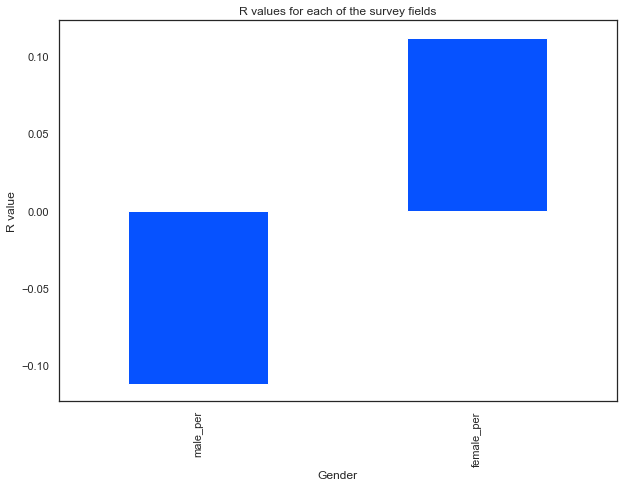

In [17]:
gender_corr = correlations[['male_per', 'female_per']]
plt.figure(figsize=(10,7))
ax = gender_corr.plot.bar(color=sns.xkcd_rgb['electric blue'])
ax.set_title('R values for each of the survey fields')
ax.set_ylabel('R value')
ax.set_xlabel('Gender')
plt.show()

Looking at the correlation between gender is interesting, we can males are negatively correlated, where females are positively correlated. Lets dig in a little deeper to see the SAT scores where there is a high female percentage.

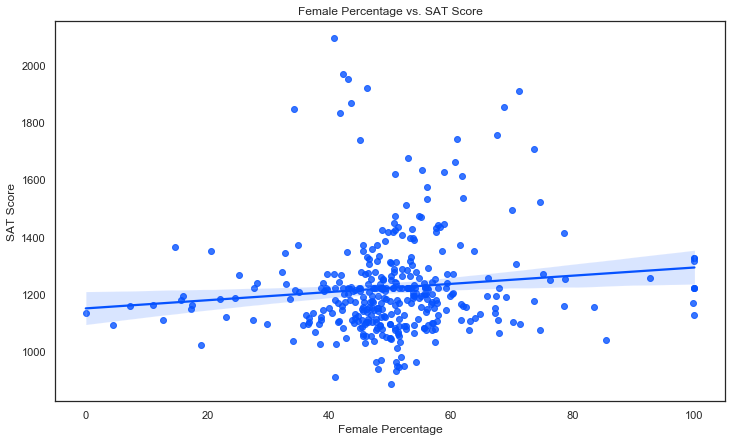

In [18]:
female = combined[['DBN','SCHOOL NAME','female_per','sat_score','school_type']].sort_values(by=['female_per', 'sat_score'], ascending=False)
plt.figure(figsize=(12,7))
sns.set_style("white")
ax = sns.regplot(data=female, x='female_per', y='sat_score', color=sns.xkcd_rgb['electric blue'])
ax.set_title('Female Percentage vs. SAT Score')
ax.set_xlabel('Female Percentage')
ax.set_ylabel('SAT Score')
plt.show()

From the above plot it looks like there is a very slight upward increase in SAT scores as the percentage of females increases. However, there is a large spread of values between 60-80% that could be contributing to the positive relationship we observed. At 100% females the schools are not that far from the mean SAT scores.

In [19]:
top_female = female[(female['female_per'] > 60) & (female['sat_score'] > 1700)]
top_female.head(15)

,DBN,SCHOOL NAME,female_per,sat_score,school_type
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0,Specialized School
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0,0
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0,0
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0,0
60,03M479,BEACON HIGH SCHOOL,61.0,1744.0,Consortium School


It appears that there are a few outlier schools which could be causing the postive correlation. For example the above 5 schools are very selective schools that require students to have a extremely good grades before addmission. Further some of them report haveing a very high student to teacher ratio in comparision to other schools.

## Taking Advanced Placement into Consideration

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

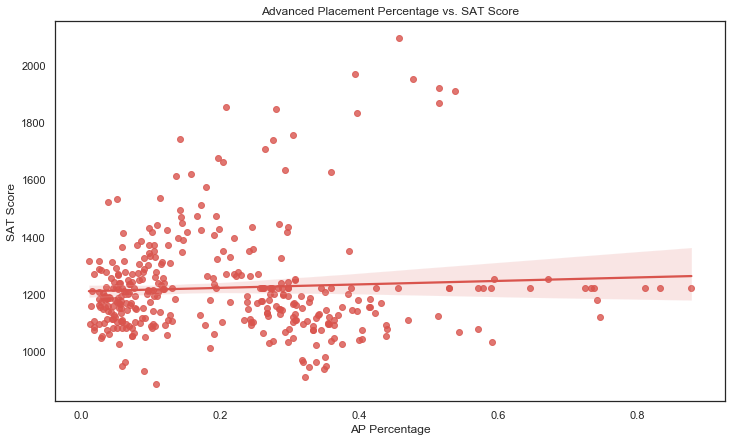

In [21]:
# Calculating the percentage of students that took AP exams and creating a new column with the results
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

# Plotting out the relationship between AP percent and SAT scores
plt.figure(figsize=(12,7))
sns.set_style("white")
ax = sns.regplot(data=combined, x='ap_per', y='sat_score', color=sns.xkcd_rgb['pale red'])
ax.set_title('Advanced Placement Percentage vs. SAT Score')
ax.set_xlabel('AP Percentage')
ax.set_ylabel('SAT Score')
plt.show()